<h1>Assignment 3b: Physics-Informed Neural Networks</h1>
In this part of the assignment, you'll implement a vanilla PINN (Physics-Informed Neural Network).  We follow closely the tutorial in  https://arxiv.org/pdf/2403.00599v1, Section 2.

The Laplace equation is a partial differential equation (PDE) ubiquitous in physics and mathematics, used for describing phenomena in gravitation, fluid flow, electromagnetism, among others.  The equation in 2 dimensions is

$$\frac{\partial^2}{\partial x^2}u(x,y) + \frac{\partial^2}{\partial y^2}u(x,y) = 0$$

where $u:\mathbb{R}^2 \to \mathbb{R}$ is a smooth function defined on a subset of $\mathbb{R}$.


For a given domain $\Omega\subset \mathbb{R}^2$ and a fixed function $f:\partial\Omega\to \mathbb{R}$ defining the value of $u$ on the boundary of the domain, a common task in scientific computing is to find a function $u:\Omega\to \mathbb{R}$ satifying the Laplace equation, i.e. a $u$ so that
$$\frac{\partial^2}{\partial x^2}u(x,y) + \frac{\partial^2}{\partial y^2}u(x,y) = 0 \quad\quad\forall (x,y) \in \Omega$$
$$u(x,y) = f(x,y) \quad\quad\forall (x,y) \in \partial\Omega$$

PINN is an approach which defines a small neural network representing $u$, and a loss which encourages it to solve these equations.  The hope is that by training the neural network, we can recover a solution to the PDE for given boundary conditions.

<h3>Question 1</h3>
Show (provide an analytic solution) that the function $u(x,y)=x^2-y^2$ satisfies the Laplace equation $\forall (x,y) \in \mathbb{R}^2$.

###
\#\#\#\#\# YOUR SOLUTION TYPED HERE\#\#\#\#\#
$$\frac{\partial^2 u(x, y)}{\partial x^2} = 2\times \frac{\partial x}{\partial x} = 2$$
$$\frac{\partial^2 u(x, y)}{\partial y^2} = -2\times \frac{\partial y}{\partial y} = -2$$
$$\therefore \frac{\partial^2 u(x, y)}{\partial x^2} + \frac{\partial^2 u(x, y)}{\partial y^2} = 0, \forall (x, y) \in \Omega$$
###

<h2>Network Definition</h2>
<h3>Question 2</h3>
Define a neural network with
<ul>
    <li>Input: a tensor of input size 2</li>
    <li>Output: a tensor of output size 1</li>
    <li>5 hidden layers with 20 neurons each</li>
    <li>tanh activation functions for the hidden layers</li>
</ul>

In [1]:
import torch.nn as nn
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats.qmc import LatinHypercube
from tqdm import tqdm

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        ##### DEFINE YOUR LAYERS HERE #####
        input_size = 2; output_size = 1; hidden_size = 20
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.Tanh(),   # 1
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),  # 2
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),  # 3
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),  # 4
            nn.Linear(hidden_size, output_size))             # 5
        
        ##### ----------------------- #####

    def forward(self, x):
        ##### DEFINE THE FORWARD PART OF YOUR NETWORK HERE #####
        return self.network(x)
        
        ##### -------------------------------------------- #####

<h2>Boundary Loss Definition</h2>
To enforce the boundary conditions, we sample points on the boundary of the domain and use the mean squared error vs the fixed boundary conditions we want to enforce.

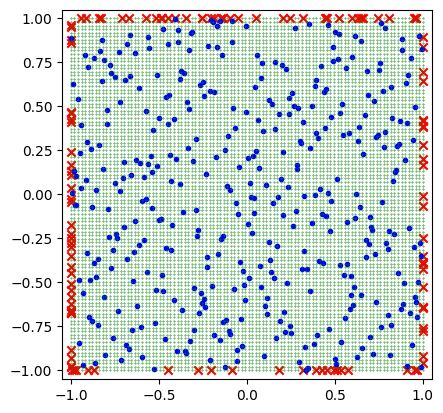

In [2]:
n_bdry = 120
n_interior = 400

# set up boundary points
x_boundary = 2*torch.rand(n_bdry, 2).double() - 1
I = torch.randint(2, size=(n_bdry,)).long()
x_boundary[torch.arange(n_bdry), I] = 2*torch.randint(2, size=(n_bdry,)).double()-1

# set up interior points
x_interior = 2*torch.from_numpy(LatinHypercube(2).random(n_interior))-1
x_interior.requires_grad = True

# set up evaluation (grid) points
n = 100
xx = np.linspace(-1, 1, n)
yy = np.linspace(-1, 1, n)
gx, gy = np.meshgrid(xx, yy)
x_eval = torch.from_numpy(np.stack([gx, gy]).reshape((2, n*n)).T)

# plot the boundary points, interior points, and evaluation points
plt.scatter(x_boundary.cpu().numpy()[:, 0], x_boundary.cpu().numpy()[:, 1], color='red', marker='x')
plt.scatter(x_interior.detach().cpu().numpy()[:, 0], x_interior.detach().cpu().numpy()[:, 1], color='blue', marker='.')
plt.scatter(x_eval.detach().cpu().numpy()[:, 0], x_eval.detach().cpu().numpy()[:, 1], color='green', marker='.', s=0.5)
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.gca().set_aspect('equal', 'box')

<h3>Question 3</h3>

Implement the mean squared error boundary loss.

In [3]:
def boundary_loss(network, bdry_pts, bdry_values):
    """
    inputs: 
        network, a differentiable function (neural network) taking points (b, 2) to values (b, 1)
        bdry_pts, a set of points (b, 2) on the boundary of the domain
        bdry_values, a set of values of f (b, 1) at the bdry_pts

    output:
        a single number, the mean-squared-error of the network at the boundary
    """
    
    ##### evaluate network on the boundary points and do mean-squared-error loss against the ground truth values at those points ##### 
    # L_data: boundary error
    y_hat = network(bdry_pts)
    assert y_hat.shape == bdry_values.shape
    return torch.mean((y_hat - bdry_values) ** 2)
    ##### ------------------------------------------------------------------------------------------------------- #####

<h2>PDE Loss Definition</h2>

In the interior of the domain, we evaluate a PDE loss which depends on the second derivative of the neural network.  Explicitly, if $u_\theta$ is our neural network, our loss for the Laplace problem is defined as 

$$\frac{1}{n_{\text{interior}}}\sum_{i=1}^{n_{\text{interior}}}\|\frac{\partial^2}{\partial x^2}u_\theta + \frac{\partial^2}{\partial y^2}u_\theta\|^2$$

This may seem weird: most standard data-scientific neural networks do not use the derivative of the network in the loss!  Fortunately, many automatic differentiation libraries are able to derive with respect to derivatives of a network.  Pytorch has a method called ```torch.autograd.grad``` for these purposes.

<h3>Question 4</h3>

Please research how to use ```torch.autograd.grad``` online.  Below, use ```torch.autograd.grad``` to implement the second partial derivatives in the x and y directions.

In [4]:
def double_partial_x(u, pts):
    """
    inputs:
        u, a differentiable function (/neural network) taking points (b, 2) to values (b, 1)
        pts, a (b, 2) tensor representing the points to evaluate second derivatives at
    outputs:
        d2u, the second partial derivative of u in the x direction of shape (b, 1), evaluated at the points pts
    """
    
    ##### YOUR CODE HERE #####
    # ref: https://discuss.pytorch.org/t/2nd-order-differential-for-pinn-model/117834/2
    pts.requires_grad = True
    
    U = u(pts)
    U_x = torch.autograd.grad(U, pts, create_graph=True, 
                              grad_outputs=torch.ones_like(U), allow_unused=True)[0][:, 0:1]
    U_xx = torch.autograd.grad(U_x, pts, create_graph=True,
                               grad_outputs=torch.ones_like(U_x), allow_unused=True)[0][:, 0:1]
    return U_xx
    ##### -------------- #####

def double_partial_y(u, pts):
    """
    inputs:
        u, a differentiable function (/neural network) taking points (b, 2) to values (b, 1)
        pts, a (b, 2) tensor representing the points to evaluate second derivatives at
    outputs:
        d2u, the second partial derivative of u in the y direction of shape (b, 1), evaluated at the points pts
    """
    
    ##### YOUR CODE HERE #####
    # ref: https://discuss.pytorch.org/t/2nd-order-differential-for-pinn-model/117834/2
    pts.requires_grad = True
    
    U = u(pts)
    U_y = torch.autograd.grad(U, pts, create_graph=True, 
                              grad_outputs=torch.ones_like(U), allow_unused=True)[0][:, 1:2]
    U_yy = torch.autograd.grad(U_y, pts, create_graph=True,
                               grad_outputs=torch.ones_like(U_y), allow_unused=True)[0][:, 1:2]
    return U_yy

    ##### -------------- #####

You can test your implementation by running the following, which evaluates the second partial derivatives of the functions
$$u_1(x, y) = 2.1x - 3.4y$$
$$u_2(x, y) = x^2 + y^2$$
$$u_3(x, y) = xy^3$$
and finds the mean squared error.  The error should be very close to 0.

In [5]:
u1 = lambda pts: torch.sum(torch.Tensor([[2.1, -3.4]])*pts**1, dim=1)
u2 = lambda pts: pts[:, 0:1]**2 + pts[:, 1:2]**2
u3 = lambda pts: pts[:, 0:1]*pts[:, 1:2]**3

expected_ddx_u1 = lambda pts: torch.zeros((pts.shape[0], 1)).double()
expected_ddy_u1 = lambda pts: torch.zeros((pts.shape[0], 1)).double()
expected_ddx_u2 = lambda pts: 2*torch.ones((pts.shape[0], 1)).double()
expected_ddy_u2 = lambda pts: 2*torch.ones((pts.shape[0], 1)).double()
expected_ddx_u3 = lambda pts: torch.zeros((pts.shape[0], 1)).double()
expected_ddy_u3 = lambda pts: 6*pts[:, 0:1]*pts[:, 1:2]

print("u1 double partial x error", torch.mean((double_partial_x(u1, x_interior) - expected_ddx_u1(x_interior))**2).item())
print("u1 double partial y error", torch.mean((double_partial_y(u1, x_interior) - expected_ddy_u1(x_interior))**2).item())

print("\n")
print("u2 double partial x error", torch.mean((double_partial_x(u2, x_interior) - expected_ddx_u2(x_interior))**2).item())
print("u2 double partial y error", torch.mean((double_partial_y(u2, x_interior) - expected_ddy_u2(x_interior))**2).item())

print("\n")
print("u3 double partial x error", torch.mean((double_partial_x(u3, x_interior) - expected_ddx_u3(x_interior))**2).item())
print("u3 double partial y error", torch.mean((double_partial_y(u3, x_interior) - expected_ddy_u3(x_interior))**2).item())

u1 double partial x error 0.0
u1 double partial y error 0.0


u2 double partial x error 0.0
u2 double partial y error 0.0


u3 double partial x error 0.0
u3 double partial y error 0.0


<h3>Question 5</h3>

Write a function computing the PDE loss using the second derivative functions you just defined.

In [6]:
def laplace_pde_loss(u, pts):
    """
    inputs:
        u, a differentiable function (/neural network) taking points (b, 2) to values (b, 1)
        pts, points to evaluate the loss at
    """

    ##### YOUR CODE HERE #####
    # L_PDE: PDE Loss
    dxx = double_partial_x(u, pts)
    dyy = double_partial_y(u, pts)
    return torch.mean((dxx + dyy) ** 2)

    ##### -------------- #####

Now train the PINN using the two losses.  Please keep the learning rate, etc the same and just run the following cell.

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [01:50<00:00, 543.17it/s]


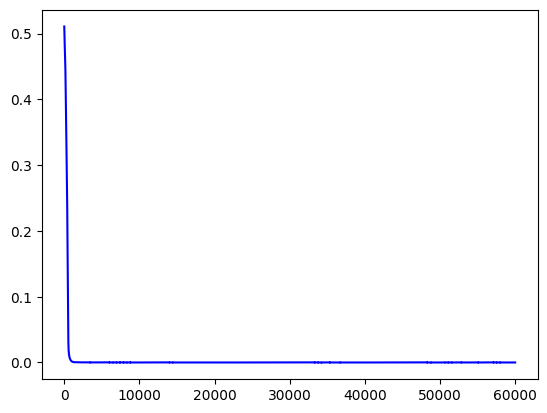

In [7]:
epochs = 60000
lr = 2e-4
lam_pde = 1.0
test_step = 1000

boundary_data = x_boundary[:, 0:1]**2 - x_boundary[:, 1:2]**2

net = PINN().double()
optim = torch.optim.Adam(net.parameters(), lr=lr)

losses = []
eval_losses = []
for epoch in tqdm(range(epochs)):
    optim.zero_grad()

    b_loss = boundary_loss(net, x_boundary, boundary_data)
    p_loss = laplace_pde_loss(net, x_interior)

    loss = b_loss + lam_pde*p_loss

    losses += [float(loss)]
    
    loss.backward()
    optim.step()

plt.plot(np.arange(epochs), losses, color='blue')
plt.show()

Solutions to the Laplace equation are unique when boundary conditions are specified.  Therefore we expect the result to be the function $f(x,y)=x^2-y^2$, which we used to find the boundary conditions.  To check how well this is satisfied, we can evaluate on a different set of points and plot the result:

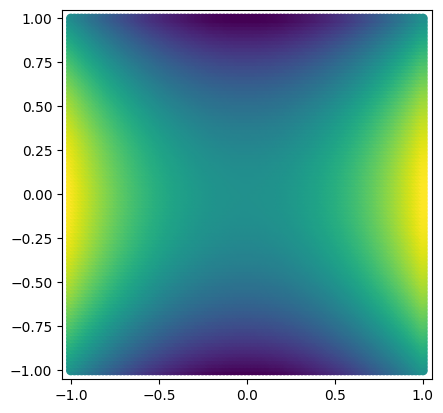

In [8]:
eval_u = net(x_eval)
plt.scatter(x_eval.cpu().detach().numpy()[:, 0], x_eval.cpu().detach().numpy()[:, 1], c=eval_u.cpu().detach().numpy())
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.gca().set_aspect('equal', 'box')

Finally, we can plot the absolute error as well.  Your absolute error should be in the 1e-4 to 5e-3 range.

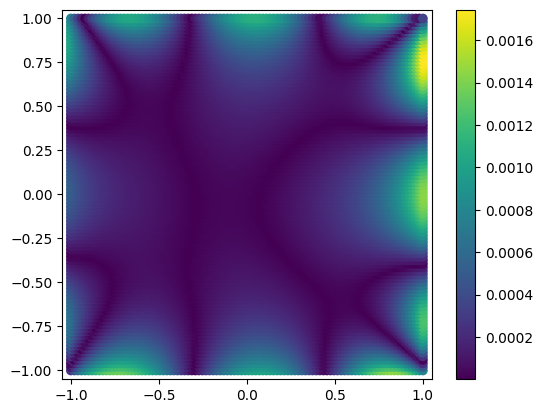

In [9]:
abs_error = np.abs(eval_u.cpu().detach().numpy() - (x_eval[:, 0:1]**2 - x_eval[:, 1:2]**2).cpu().detach().numpy())
plt.scatter(x_eval.cpu().detach().numpy()[:, 0], x_eval.cpu().detach().numpy()[:, 1], c=abs_error)
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.gca().set_aspect('equal', 'box')
plt.colorbar()

<h3>Question 6</h3>
What do you observe about the spatial distribution of the error?  Why do you think the spatial distribution of the error is like that?

###
\#\#\#\#\# YOUR SOLUTION TYPED HERE\#\#\#\#\#
I can see that it shows a low error rate overall.
However, we observed slightly higher errors at all boundaries.
As explanined in the paper, we trained PiNNs to minimize the loss for both boundary data points and inner data points.
$$\frac{1}{N}\sum\limits_{i = 1}^{N}(f(x_i, y_i) - v_{x_i, y_j})$$
$$\frac{1}{N'}\sum\limits_{j = 1}^{N'}(\frac{\partial^2 f(x_j, y_j)}{\partial x^2} + \frac{\partial^2 f(x_j, y_j)}{\partial y^2})$$
In this case, many confilcts with conditions(minimize total loss) may occurs at the boundaries, and learning may be relatively unstable compared to other points.
###

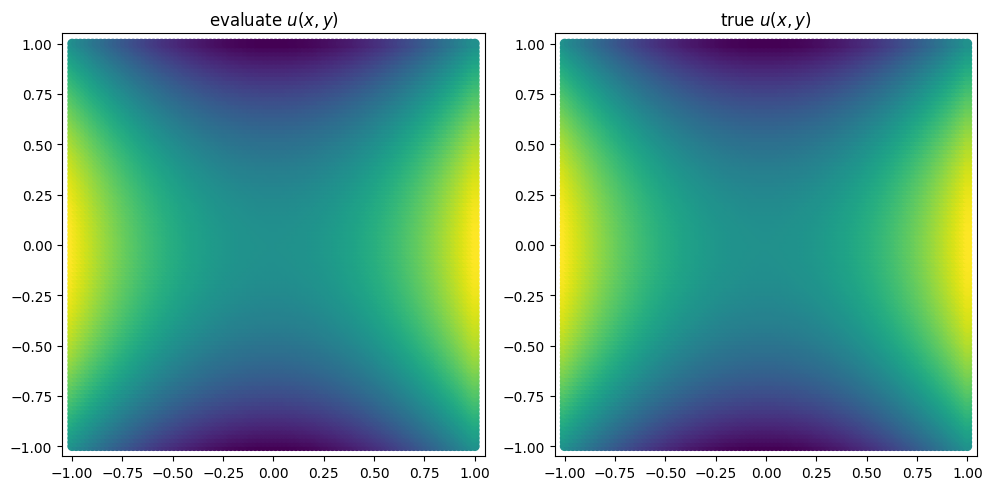

In [10]:
def true_function(x_eval):
    return x_eval[:, 0] ** 2 - x_eval[:, 1] ** 2

true_u = true_function(x_eval)
eval_u = net(x_eval)

fig, axes = plt.subplots(1, 2, figsize=(10, 14))
axes[0].scatter(x_eval.cpu().detach().numpy()[:, 0], x_eval.cpu().detach().numpy()[:, 1], c=eval_u.cpu().detach().numpy())
axes[0].set_xlim(-1.05, 1.05)
axes[0].set_ylim(-1.05, 1.05)
axes[0].set_aspect('equal', 'box')
axes[0].set_title("evaluate $u(x, y)$")

axes[1].scatter(x_eval.cpu().detach().numpy()[:, 0], x_eval.cpu().detach().numpy()[:, 1], c=true_u)
axes[1].set_xlim(-1.05, 1.05)
axes[1].set_ylim(-1.05, 1.05)
axes[1].set_aspect('equal', 'box')
axes[1].set_title("true $u(x, y)$")

plt.tight_layout()
plt.show()